In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:53 - loss: 0.0472 - STD: 1.9521e-04 - MAE: 0.2003

 4/74 [>.............................] - ETA: 18s - loss: 0.0233 - STD: 2.8497e-04 - MAE: 0.1184 

 7/74 [=>............................] - ETA: 9s - loss: 0.0229 - STD: 2.3644e-04 - MAE: 0.1186 

10/74 [===>..........................] - ETA: 6s - loss: 0.0214 - STD: 2.1020e-04 - MAE: 0.1135

13/74 [====>.........................] - ETA: 5s - loss: 0.0188 - STD: 2.0278e-04 - MAE: 0.1051

15/74 [=====>........................] - ETA: 4s - loss: 0.0176 - STD: 2.0332e-04 - MAE: 0.1025

17/74 [=====>........................] - ETA: 3s - loss: 0.0171 - STD: 2.0593e-04 - MAE: 0.1019

20/74 [=======>......................] - ETA: 3s - loss: 0.0161 - STD: 2.1152e-04 - MAE: 0.0997

22/74 [=======>......................] - ETA: 3s - loss: 0.0154 - STD: 2.1488e-04 - MAE: 0.0974

25/74 [=========>....................] - ETA: 2s - loss: 0.0148 - STD: 2.1858e-04 - MAE: 0.0946

28/74 [==========>...................] - ETA: 2s - loss: 0.0143 - STD: 2.2277e-04 - MAE: 0.0926

31/74 [===========>..................] - ETA: 2s - loss: 0.0138 - STD: 2.3022e-04 - MAE: 0.0907

34/74 [============>.................] - ETA: 1s - loss: 0.0134 - STD: 2.4149e-04 - MAE: 0.0896

37/74 [==============>...............] - ETA: 1s - loss: 0.0131 - STD: 2.5530e-04 - MAE: 0.0889

39/74 [==============>...............] - ETA: 1s - loss: 0.0129 - STD: 2.6450e-04 - MAE: 0.0884

42/74 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.7787e-04 - MAE: 0.0875

45/74 [=================>............] - ETA: 1s - loss: 0.0124 - STD: 2.9044e-04 - MAE: 0.0865

48/74 [==================>...........] - ETA: 1s - loss: 0.0122 - STD: 3.0456e-04 - MAE: 0.0858

51/74 [===================>..........] - ETA: 0s - loss: 0.0121 - STD: 3.2124e-04 - MAE: 0.0851

54/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 3.4115e-04 - MAE: 0.0846

57/74 [======================>.......] - ETA: 0s - loss: 0.0118 - STD: 3.6327e-04 - MAE: 0.0843

60/74 [=======================>......] - ETA: 0s - loss: 0.0116 - STD: 3.8631e-04 - MAE: 0.0838

63/74 [========================>.....] - ETA: 0s - loss: 0.0115 - STD: 4.1080e-04 - MAE: 0.0833

66/74 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 4.3796e-04 - MAE: 0.0829

69/74 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 4.6947e-04 - MAE: 0.0826

72/74 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 5.0583e-04 - MAE: 0.0823

74/74 [==============================] - 5s 44ms/step - loss: 0.0112 - STD: 5.3251e-04 - MAE: 0.0821 - val_loss: 0.0085 - val_STD: 0.0011 - val_MAE: 0.0714


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0090 - STD: 0.0016 - MAE: 0.0750

 4/74 [>.............................] - ETA: 1s - loss: 0.0092 - STD: 0.0017 - MAE: 0.0756

 7/74 [=>............................] - ETA: 1s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0751

10/74 [===>..........................] - ETA: 1s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0749

13/74 [====>.........................] - ETA: 1s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0749

16/74 [=====>........................] - ETA: 1s - loss: 0.0091 - STD: 0.0023 - MAE: 0.0750

19/74 [======>.......................] - ETA: 1s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0749

22/74 [=======>......................] - ETA: 1s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0748

24/74 [========>.....................] - ETA: 1s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0747

27/74 [=========>....................] - ETA: 1s - loss: 0.0090 - STD: 0.0033 - MAE: 0.0746

30/74 [===========>..................] - ETA: 1s - loss: 0.0090 - STD: 0.0037 - MAE: 0.0746

33/74 [============>.................] - ETA: 0s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0744

35/74 [=============>................] - ETA: 0s - loss: 0.0089 - STD: 0.0046 - MAE: 0.0743

38/74 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0742

41/74 [===============>..............] - ETA: 0s - loss: 0.0088 - STD: 0.0059 - MAE: 0.0739

44/74 [================>.............] - ETA: 0s - loss: 0.0087 - STD: 0.0068 - MAE: 0.0737

47/74 [==================>...........] - ETA: 0s - loss: 0.0087 - STD: 0.0077 - MAE: 0.0735

50/74 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 0.0088 - MAE: 0.0733

53/74 [====================>.........] - ETA: 0s - loss: 0.0085 - STD: 0.0100 - MAE: 0.0730

55/74 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.0109 - MAE: 0.0728

57/74 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.0117 - MAE: 0.0727

59/74 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.0126 - MAE: 0.0725

62/74 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0138 - MAE: 0.0722

65/74 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0150 - MAE: 0.0720

68/74 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0161 - MAE: 0.0717

70/74 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0168 - MAE: 0.0716

72/74 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.0175 - MAE: 0.0714

74/74 [==============================] - ETA: 0s - loss: 0.0082 - STD: 0.0181 - MAE: 0.0713

74/74 [==============================] - 2s 29ms/step - loss: 0.0082 - STD: 0.0181 - MAE: 0.0713 - val_loss: 0.0065 - val_STD: 0.0270 - val_MAE: 0.0613


Epoch 3/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0663

 3/74 [>.............................] - ETA: 2s - loss: 0.0071 - STD: 0.0410 - MAE: 0.0661

 5/74 [=>............................] - ETA: 2s - loss: 0.0071 - STD: 0.0413 - MAE: 0.0659

 7/74 [=>............................] - ETA: 1s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0657

 9/74 [==>...........................] - ETA: 1s - loss: 0.0071 - STD: 0.0417 - MAE: 0.0657

12/74 [===>..........................] - ETA: 1s - loss: 0.0071 - STD: 0.0422 - MAE: 0.0657

15/74 [=====>........................] - ETA: 1s - loss: 0.0070 - STD: 0.0426 - MAE: 0.0655

18/74 [======>.......................] - ETA: 1s - loss: 0.0070 - STD: 0.0428 - MAE: 0.0654

21/74 [=======>......................] - ETA: 1s - loss: 0.0070 - STD: 0.0430 - MAE: 0.0653

24/74 [========>.....................] - ETA: 1s - loss: 0.0070 - STD: 0.0431 - MAE: 0.0650

27/74 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.0432 - MAE: 0.0649

30/74 [===========>..................] - ETA: 1s - loss: 0.0069 - STD: 0.0433 - MAE: 0.0648

33/74 [============>.................] - ETA: 1s - loss: 0.0069 - STD: 0.0436 - MAE: 0.0646

35/74 [=============>................] - ETA: 0s - loss: 0.0069 - STD: 0.0437 - MAE: 0.0645

37/74 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0438 - MAE: 0.0644

39/74 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0440 - MAE: 0.0643

42/74 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0442 - MAE: 0.0640

45/74 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0443 - MAE: 0.0638

48/74 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0445 - MAE: 0.0636

50/74 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0447 - MAE: 0.0634

53/74 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0450 - MAE: 0.0632

56/74 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0453 - MAE: 0.0629

58/74 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0457 - MAE: 0.0627

61/74 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0462 - MAE: 0.0625

64/74 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0467 - MAE: 0.0622

67/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0473 - MAE: 0.0620

70/74 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0478 - MAE: 0.0617

72/74 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0481 - MAE: 0.0616

74/74 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0484 - MAE: 0.0614

74/74 [==============================] - 2s 29ms/step - loss: 0.0063 - STD: 0.0484 - MAE: 0.0614 - val_loss: 0.0049 - val_STD: 0.0448 - val_MAE: 0.0523


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0551

 3/74 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0552

 5/74 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0552

 8/74 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0605 - MAE: 0.0552

10/74 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0552

12/74 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0602 - MAE: 0.0552

15/74 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0604 - MAE: 0.0552

17/74 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0609 - MAE: 0.0553

19/74 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0551

22/74 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0551

24/74 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0552

27/74 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0552

30/74 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0607 - MAE: 0.0551

33/74 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0606 - MAE: 0.0549

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0606 - MAE: 0.0548

38/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0548

40/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0607 - MAE: 0.0547

43/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0546

45/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0546

48/74 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0545

51/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0612 - MAE: 0.0544

53/74 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0612 - MAE: 0.0542

55/74 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0614 - MAE: 0.0542

58/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0616 - MAE: 0.0541

60/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0617 - MAE: 0.0540

62/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0539

64/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0539

67/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0538

70/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0536

73/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0536

74/74 [==============================] - 2s 30ms/step - loss: 0.0050 - STD: 0.0623 - MAE: 0.0535 - val_loss: 0.0043 - val_STD: 0.0509 - val_MAE: 0.0487


Epoch 5/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0510

 3/74 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0511

 5/74 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0656 - MAE: 0.0509

 8/74 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0509

10/74 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0509

13/74 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0509

15/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0509

18/74 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0509

21/74 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0508

24/74 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0508

26/74 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0507

28/74 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0506

30/74 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0507

33/74 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0507

35/74 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0507

38/74 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0507

40/74 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0507

42/74 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0507

45/74 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0507

47/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0507

49/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0506

51/74 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0506

54/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0505

56/74 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0505

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0505

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0505

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0505

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0505

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0505

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0505

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0505

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0505

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0504

74/74 [==============================] - 2s 31ms/step - loss: 0.0045 - STD: 0.0669 - MAE: 0.0504 - val_loss: 0.0041 - val_STD: 0.0589 - val_MAE: 0.0498


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0529

 3/74 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0673 - MAE: 0.0499

 6/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0500

 9/74 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0502

12/74 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0501

15/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0502

17/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0501

19/74 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0504

21/74 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

24/74 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0517

26/74 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0658 - MAE: 0.0520

28/74 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0662 - MAE: 0.0525

30/74 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0525

32/74 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0651 - MAE: 0.0529

34/74 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0528

37/74 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0640 - MAE: 0.0531

39/74 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0530

41/74 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0530

43/74 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0529

45/74 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0528

47/74 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0528

49/74 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0527

51/74 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0527

53/74 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0525

55/74 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0524

57/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0523

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0522

61/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0521

64/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0520

66/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0519

68/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0518

71/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0517

73/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0516

74/74 [==============================] - 2s 30ms/step - loss: 0.0047 - STD: 0.0649 - MAE: 0.0516 - val_loss: 0.0039 - val_STD: 0.0583 - val_MAE: 0.0473


Epoch 7/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0483

 3/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0481

 5/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0485

 8/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0485

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0485

13/74 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0485

15/74 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0485

17/74 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0485

19/74 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0485

22/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0485

24/74 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0485

26/74 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0485

28/74 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0484

31/74 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0484

33/74 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0484

35/74 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0484

38/74 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0484

40/74 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0484

42/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0484

44/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0484

47/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0483

49/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0483

51/74 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0483

53/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0483

55/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0483

57/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0483

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0482

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0482

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0482

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0481

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

74/74 [==============================] - 2s 30ms/step - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481 - val_loss: 0.0037 - val_STD: 0.0626 - val_MAE: 0.0473


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0496

 3/74 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0484

 6/74 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0483

 9/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0485

11/74 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0491

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0498

15/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0500

17/74 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0687 - MAE: 0.0505

19/74 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0504

21/74 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0675 - MAE: 0.0506

23/74 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0506

25/74 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0506

28/74 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0506

30/74 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0504

33/74 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0504

36/74 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0503

38/74 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0501

40/74 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0501

42/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0500

44/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0499

46/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0498

48/74 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0498

50/74 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0497

52/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0496

54/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0496

56/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0495

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0494

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0494

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0493

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0493

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0492

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0491

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0491

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490

74/74 [==============================] - 2s 31ms/step - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490 - val_loss: 0.0036 - val_STD: 0.0589 - val_MAE: 0.0451


Epoch 9/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0478

 3/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

 5/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0470

 7/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

10/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0471

12/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0472

14/74 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0471

16/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

18/74 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

20/74 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0470

22/74 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0470

25/74 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0470

28/74 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0470

31/74 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0470

33/74 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0470

35/74 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

37/74 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0470

40/74 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0470

42/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0470

44/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0470

47/74 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

49/74 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0472

51/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0473

53/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0473

55/74 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0476

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0476

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0476

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0476

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0476

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

74/74 [==============================] - 2s 30ms/step - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475 - val_loss: 0.0036 - val_STD: 0.0590 - val_MAE: 0.0441


Epoch 10/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0462

 3/74 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0466

 6/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0467

 8/74 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

10/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

12/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

14/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

16/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

18/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

20/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

23/74 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

25/74 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

28/74 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

30/74 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0464

32/74 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0464

35/74 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0464

38/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0463

40/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0463

42/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0463

44/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0463

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

48/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

51/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

53/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

55/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

74/74 [==============================] - 2s 30ms/step - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462 - val_loss: 0.0034 - val_STD: 0.0600 - val_MAE: 0.0434


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0711 - MAE: 0.0456

 3/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0458

 6/74 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

 8/74 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

11/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

13/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

16/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

18/74 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0459

20/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

22/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

24/74 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

26/74 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

28/74 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

31/74 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

33/74 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

35/74 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

37/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

40/74 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

42/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

45/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

47/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

49/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

51/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

54/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

56/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

74/74 [==============================] - 2s 31ms/step - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459 - val_loss: 0.0033 - val_STD: 0.0621 - val_MAE: 0.0432


Epoch 12/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0458

 3/74 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0460

 5/74 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

 8/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

10/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

12/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

14/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

16/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

21/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0456

23/74 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

25/74 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0456

27/74 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

29/74 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

32/74 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

35/74 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

37/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

39/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

42/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

44/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

48/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

51/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

53/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

55/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0456

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

74/74 [==============================] - 2s 30ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455 - val_loss: 0.0032 - val_STD: 0.0612 - val_MAE: 0.0421


Epoch 13/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0720 - MAE: 0.0444

 3/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0451

 6/74 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0461

 8/74 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0464

10/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

12/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

14/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

16/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

18/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

21/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

23/74 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

25/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

27/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

29/74 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

32/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

34/74 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

36/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

38/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

41/74 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

43/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

48/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

74/74 [==============================] - 2s 30ms/step - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0644 - val_MAE: 0.0440


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0487

 3/74 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0471

 5/74 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

 8/74 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0463

10/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

13/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0458

15/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0718 - MAE: 0.0458

17/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0717 - MAE: 0.0457

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0456

21/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0456

24/74 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

27/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

30/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0452

32/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0452

34/74 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

36/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0450

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0450

40/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0449

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0449

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0448

47/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

50/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

54/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

74/74 [==============================] - 2s 30ms/step - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447 - val_loss: 0.0031 - val_STD: 0.0619 - val_MAE: 0.0413


Epoch 15/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

 3/74 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

 5/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

 7/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0452

 9/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0452

12/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

14/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0456

16/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0458

18/74 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0456

20/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0456

22/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

25/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

27/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

29/74 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

31/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

33/74 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

36/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

38/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

40/74 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

42/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

45/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

47/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

49/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0449

51/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

53/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0447

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

74/74 [==============================] - 2s 30ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446 - val_loss: 0.0031 - val_STD: 0.0615 - val_MAE: 0.0409


Epoch 16/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0434

 3/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0433

 5/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0443

12/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0443

14/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0443

17/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0443

20/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

22/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0448

24/74 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0449

26/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0448

29/74 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

31/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0448

33/74 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

35/74 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

41/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

43/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

47/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

51/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

53/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

55/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

74/74 [==============================] - 2s 30ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442 - val_loss: 0.0031 - val_STD: 0.0615 - val_MAE: 0.0406


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0435

 3/74 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0435

 5/74 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0435

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0436

 9/74 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0437

11/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

15/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

17/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

19/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

21/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

24/74 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

27/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

29/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

31/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

33/74 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

35/74 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

40/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0443

43/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

47/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

54/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0442

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0442

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

74/74 [==============================] - 2s 31ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0442 - val_loss: 0.0030 - val_STD: 0.0637 - val_MAE: 0.0410


Epoch 18/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0446

 3/74 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

 5/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

10/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

12/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

14/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

17/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

19/74 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

22/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

24/74 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

26/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

28/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

30/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

32/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

34/74 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

36/74 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

39/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

42/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

49/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

54/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

74/74 [==============================] - 2s 30ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437 - val_loss: 0.0030 - val_STD: 0.0631 - val_MAE: 0.0403


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0434

 3/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

 6/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

11/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

13/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

15/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

17/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

20/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

22/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

24/74 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

26/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

29/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

31/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

33/74 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

35/74 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

37/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

39/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

41/74 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

51/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

53/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

55/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

74/74 [==============================] - 2s 30ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432 - val_loss: 0.0029 - val_STD: 0.0641 - val_MAE: 0.0400


Epoch 20/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0428

 3/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0427

 6/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0428

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0427

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

18/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

20/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

24/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

26/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

29/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

31/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

34/74 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

36/74 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

39/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

42/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

44/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

51/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

53/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

55/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

74/74 [==============================] - 2s 30ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432 - val_loss: 0.0042 - val_STD: 0.0525 - val_MAE: 0.0459


Epoch 21/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0640 - MAE: 0.0454

 3/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0445

 5/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0442

 8/74 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0438

11/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0436

14/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0435

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

19/74 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

22/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

25/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

27/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

30/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

32/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0430

35/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0430

37/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

40/74 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

45/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

47/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

52/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

54/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

56/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

74/74 [==============================] - 2s 29ms/step - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434 - val_loss: 0.0035 - val_STD: 0.0570 - val_MAE: 0.0418


Epoch 22/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0425

 3/74 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0430

 5/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0427

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0426

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0425

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

18/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

20/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

23/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

28/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

30/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

32/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

34/74 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

36/74 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

53/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

74/74 [==============================] - 2s 31ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426 - val_loss: 0.0029 - val_STD: 0.0619 - val_MAE: 0.0394


Epoch 23/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0417

 3/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0752 - MAE: 0.0419

 6/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

11/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

14/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

16/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

18/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

20/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0420

23/74 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

26/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

29/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

31/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

33/74 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

35/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

41/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

45/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

47/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

51/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

54/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - 2s 30ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424 - val_loss: 0.0034 - val_STD: 0.0584 - val_MAE: 0.0414


Epoch 24/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0731 - MAE: 0.0423

 3/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

 5/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

18/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

20/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

24/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

27/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

29/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

33/74 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

35/74 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

41/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

51/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

54/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - 2s 30ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424 - val_loss: 0.0037 - val_STD: 0.0558 - val_MAE: 0.0428


Epoch 25/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0429

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0736 - MAE: 0.0425

 6/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0432

 9/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0428

11/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0427

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0427

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

21/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

23/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

27/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

29/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

33/74 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

36/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

53/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

74/74 [==============================] - 2s 30ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0635 - val_MAE: 0.0392


Epoch 26/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

 3/74 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0419

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

12/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

15/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

17/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

19/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

21/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

23/74 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

25/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

31/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

33/74 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

35/74 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

39/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

42/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - 2s 30ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0035 - val_STD: 0.0585 - val_MAE: 0.0416


Epoch 27/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0723 - MAE: 0.0423

 3/74 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0432

 5/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0427

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

15/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

18/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

20/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

23/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

26/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

29/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

32/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

35/74 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

39/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

41/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

74/74 [==============================] - 2s 29ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0032 - val_STD: 0.0604 - val_MAE: 0.0403


Epoch 28/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0753 - MAE: 0.0404

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

 6/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

11/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

16/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

18/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

20/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

22/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

25/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

27/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

30/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

33/74 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

36/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

47/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

54/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

74/74 [==============================] - 2s 30ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0393


Epoch 29/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0759 - MAE: 0.0399

 3/74 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

 5/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

17/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

21/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

23/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

27/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

29/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

33/74 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

35/74 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

37/74 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

42/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - 2s 31ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419 - val_loss: 0.0034 - val_STD: 0.0584 - val_MAE: 0.0412


Epoch 30/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0411

 3/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0413

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0415

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0413

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0413

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

21/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

23/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

27/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0411

29/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

33/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

35/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

45/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

51/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

74/74 [==============================] - 2s 31ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417 - val_loss: 0.0028 - val_STD: 0.0646 - val_MAE: 0.0392


Epoch 31/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0797 - MAE: 0.0420

 3/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

 6/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

11/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

17/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

24/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

26/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

34/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

39/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

41/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

45/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

74/74 [==============================] - 2s 30ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413 - val_loss: 0.0033 - val_STD: 0.0593 - val_MAE: 0.0408


Epoch 32/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0740 - MAE: 0.0413

 3/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0412

 5/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

14/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

18/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0407

20/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0407

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0407

24/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

26/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

35/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

39/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

41/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

74/74 [==============================] - 2s 30ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0391


Epoch 33/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0796 - MAE: 0.0419

 3/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0418

 6/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0410

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0409

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0410

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

17/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

21/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

23/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

27/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

29/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

34/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

36/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

74/74 [==============================] - 2s 30ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411 - val_loss: 0.0028 - val_STD: 0.0635 - val_MAE: 0.0388


Epoch 34/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0417

 3/74 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0759 - MAE: 0.0412

 6/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

12/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

14/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0415

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

21/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

23/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

26/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

35/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

51/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

53/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - 2s 30ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0034 - val_STD: 0.0595 - val_MAE: 0.0414


Epoch 35/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0751 - MAE: 0.0403

 3/74 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

 6/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

12/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0413

15/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

17/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

19/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

21/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

24/74 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

27/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

34/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

36/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

41/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

45/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

53/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

74/74 [==============================] - 2s 30ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412 - val_loss: 0.0030 - val_STD: 0.0623 - val_MAE: 0.0390


Epoch 36/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0407

 3/74 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

 5/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0406

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

24/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

26/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

33/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

35/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

39/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

74/74 [==============================] - 2s 29ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408 - val_loss: 0.0028 - val_STD: 0.0645 - val_MAE: 0.0389


Epoch 37/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0803 - MAE: 0.0408

 3/74 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

 9/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

17/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

20/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

24/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

26/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

29/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

33/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

35/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

45/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

74/74 [==============================] - 2s 30ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0031 - val_STD: 0.0625 - val_MAE: 0.0395


Epoch 38/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0400

 3/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 5/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 7/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0404

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

17/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

27/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

29/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

33/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

36/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

45/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

51/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

53/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

74/74 [==============================] - 2s 30ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407 - val_loss: 0.0030 - val_STD: 0.0623 - val_MAE: 0.0390


Epoch 39/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0757 - MAE: 0.0399

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 6/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

11/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

15/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

18/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

20/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

24/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

27/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

30/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

32/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

34/74 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

36/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

51/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

74/74 [==============================] - 2s 29ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405 - val_loss: 0.0032 - val_STD: 0.0613 - val_MAE: 0.0401


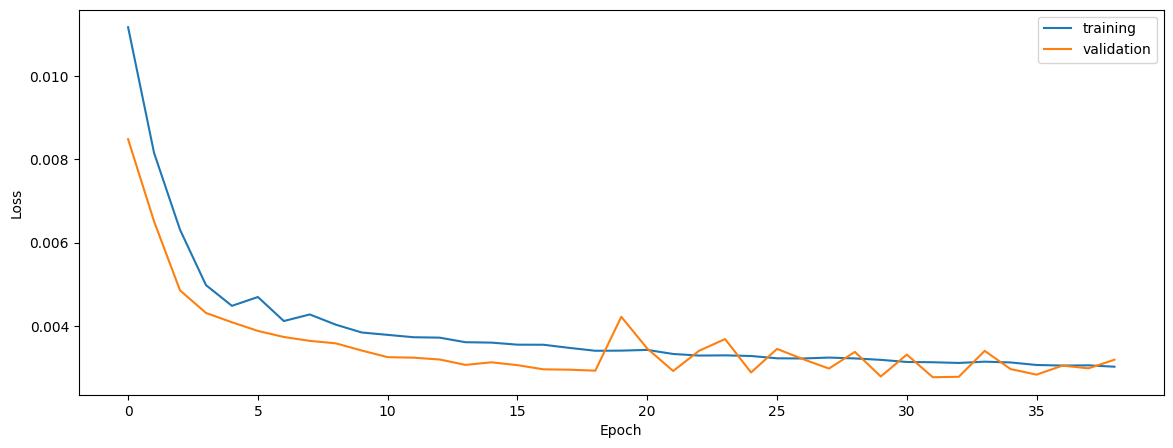

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8194532716224766
0.823488554311764
0.8076636097663804


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8194532716224766
0.823488554311764
0.8076636097663804


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8157231735210282
0.8259072728303409
0.8033260608609677


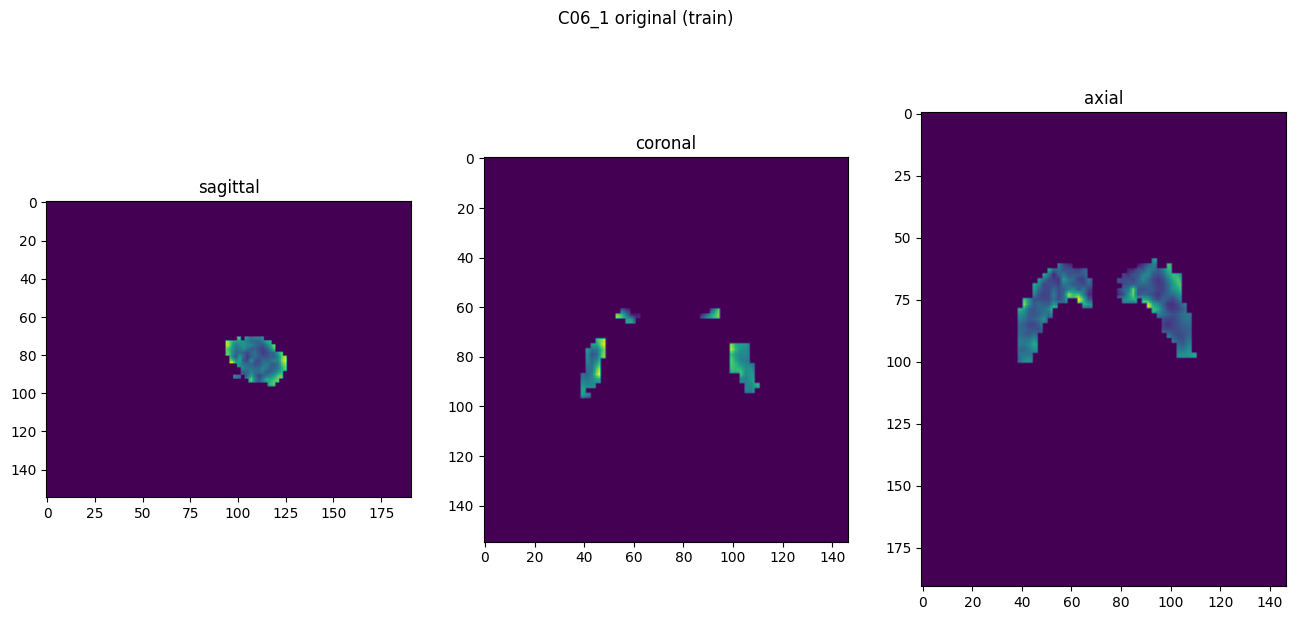

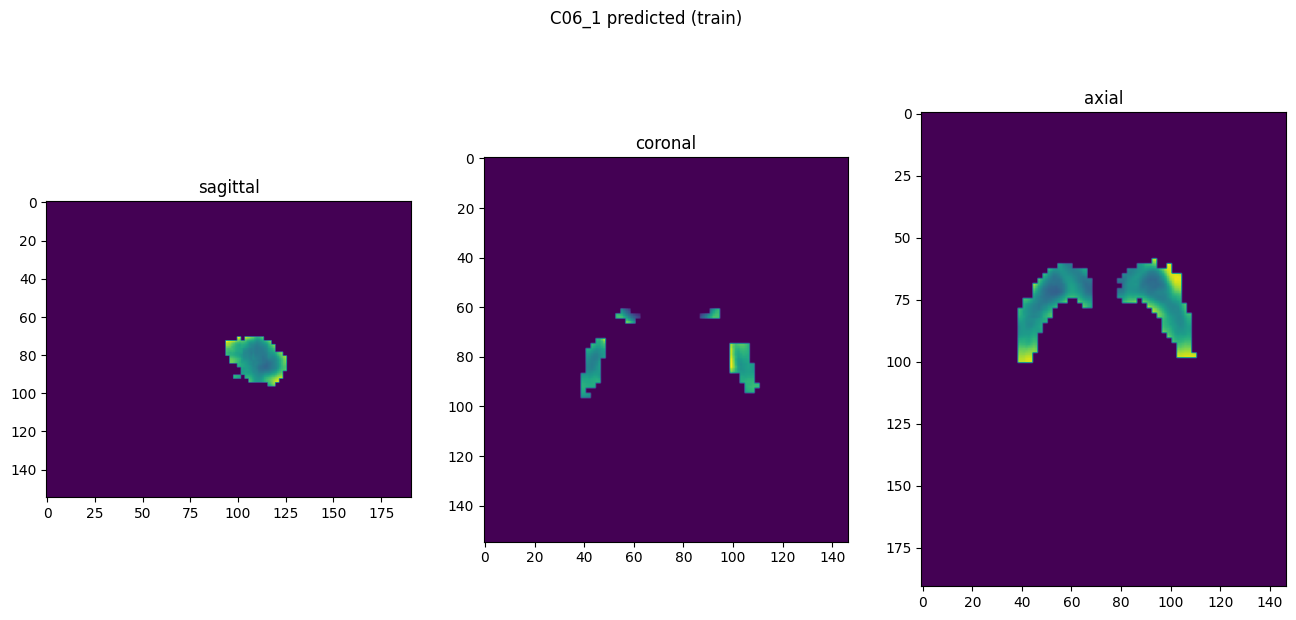

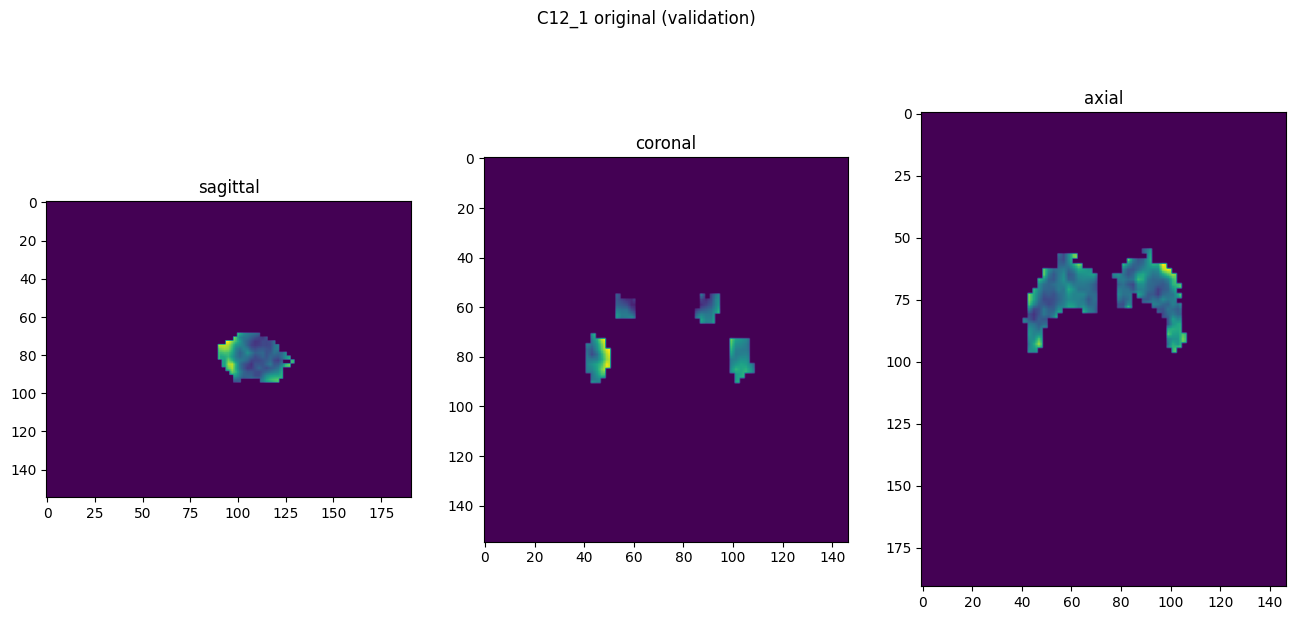

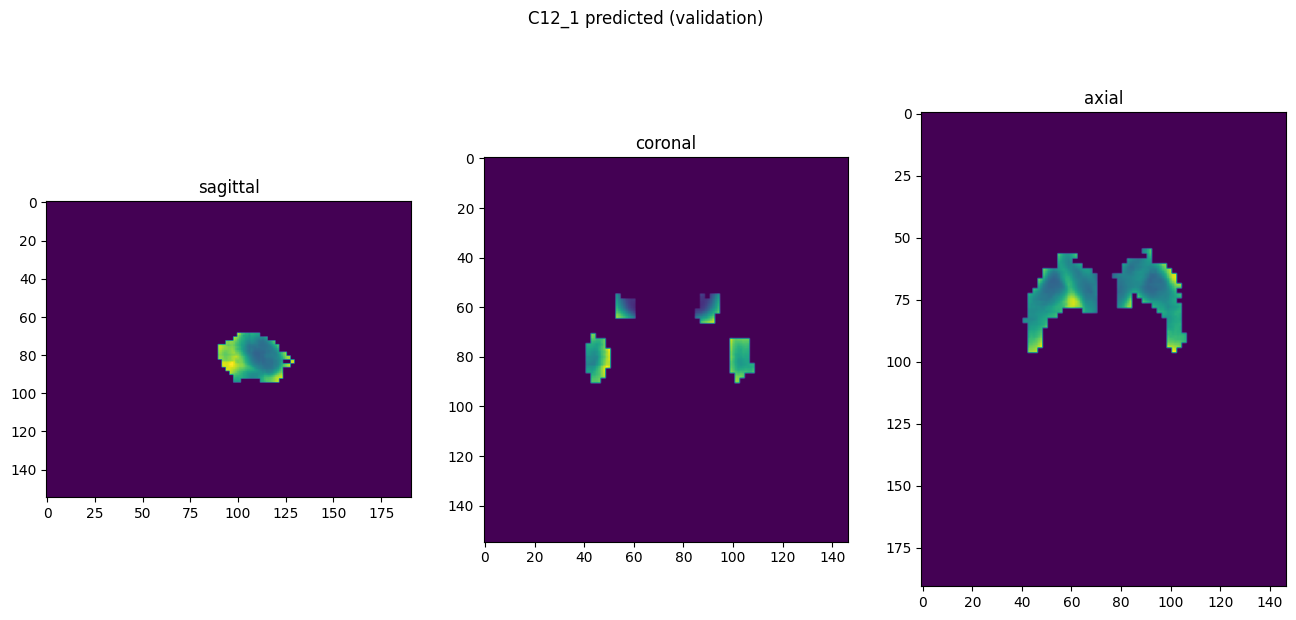

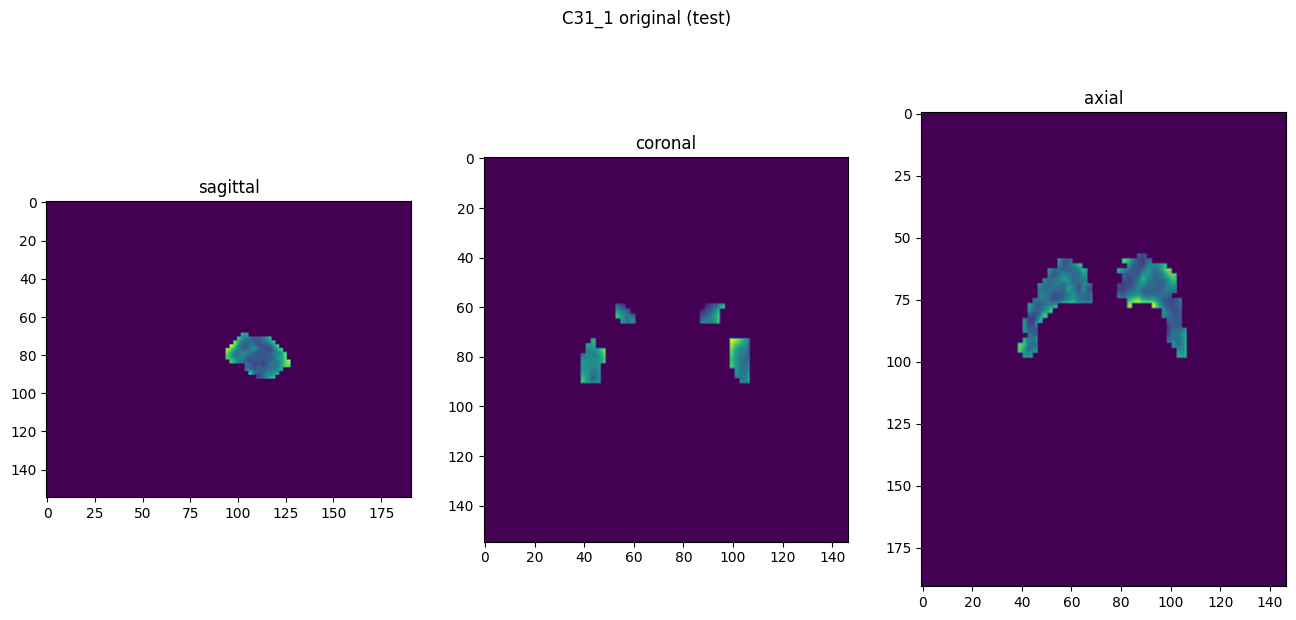

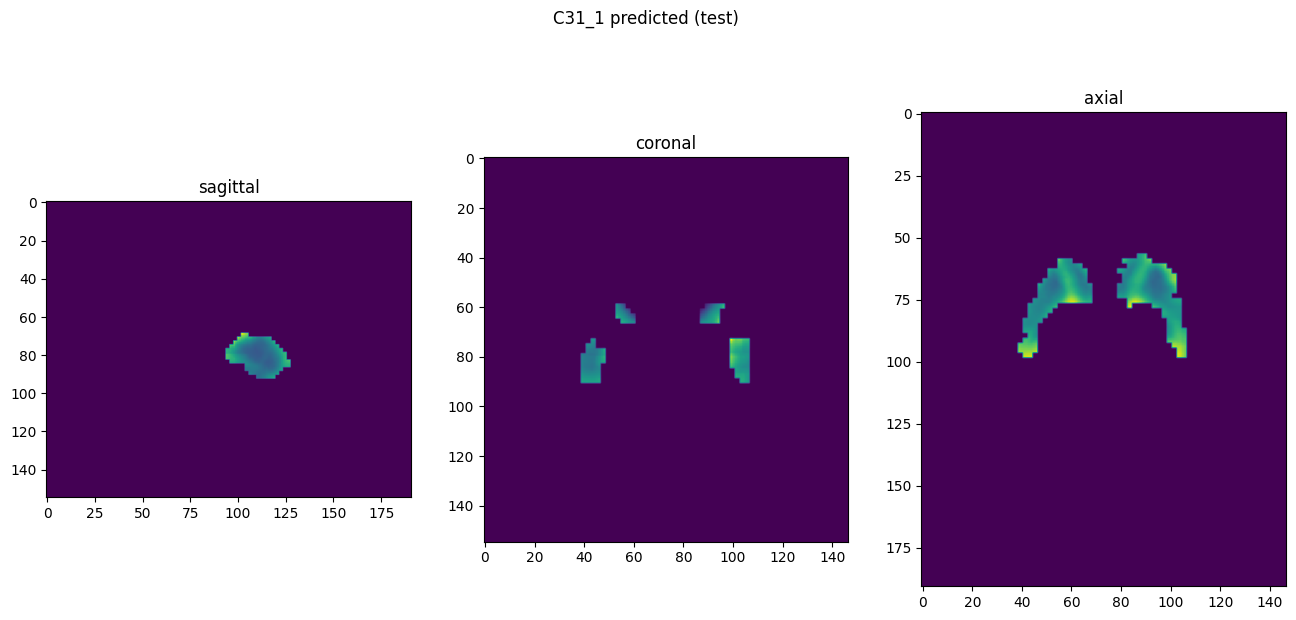

In [10]:
showResults(model, gen, threshold=None, background=False)